# Analysis

Wir, als Krankenkasse, wollen untersuchen, inwiefern Übergewicht mit unterschiedlichen Erkrankungen korreliert, also, ob nachweislich festzustellen ist, dass Menschen mit Übergewicht häufiger an bestimmten Krankheiten erkranken. 

### Bibliotheken

Zuerst werden die benötigten Bibliotheken geladen.

- [matplotlib](https://matplotlib.org/) & [seaborn](https://seaborn.pydata.org/): Sind Visualisierungs-Bibliotheken und können mathematische Darstellungen aller Art graphisch anfertigen.
- [numpy](https://numpy.org/): Ermöglicht eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays.
- [pandas](https://pandas.pydata.org/): Ist ein schnelles, leistungsstarkes, flexibles und einfaches Open-Source-Datenanalyse- und -manipulationstool.
- [sklearn, scikit-learn](https://scikit-learn.org/stable/index.htmlnumopy): Ermöglicht einfache und schnelle prädiktive Datenanalyse mit maschinellem Lernen.

In [17]:
%reset -f  # reset kernel

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  kernel, please run `%reset?` for details


# Genutzte Umgebung

Dokumentation der genutzten Bibliotheken.

In [18]:
import pandas as pd
from logger import Logger
from test_executer import TestExecutor
import sys
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import tree

logger = Logger()
testExecutor = TestExecutor(logger)

dependencies = [
    ('system', sys.version_info),
    ('pandas', pd.__version__),
    ('numpy', np.__version__),
    ('seaborn', sns.__version__),
    ('matplotlib', matplotlib.__version__),
    ('sklearn', sklearn.__version__),

]
for dependency in dependencies:
    logger.log(f"{dependency[0]} is installed with version {dependency[1]}")

{"type": "info", "time": 1658308485018, "message": "system is installed with version sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)", "params": null}
{"type": "info", "time": 1658308485019, "message": "pandas is installed with version 1.4.1", "params": null}
{"type": "info", "time": 1658308485019, "message": "numpy is installed with version 1.20.3", "params": null}
{"type": "info", "time": 1658308485020, "message": "seaborn is installed with version 0.11.2", "params": null}
{"type": "info", "time": 1658308485021, "message": "matplotlib is installed with version 3.5.1", "params": null}
{"type": "info", "time": 1658308485021, "message": "sklearn is installed with version 1.0.2", "params": null}


In [19]:
tables = [
    "conditions",
    "observations",
    "patients",
]

files = [
    "data/others/",
    "data/asthma/",
    "data/gallstones/",
    "data/hypertension/",
]

# Mit Datenbank verbinden

In [20]:
import sqlite3
from sqlite3 import Error

databaseFile = "data.sqlite"
logger.startTimeMeasurement('open-db', 'Connected to db and created tables')
connection = None
try:
    connection = sqlite3.connect(databaseFile)
except Error as err:
    logger.logError("Could not open db", err)
    if connection is not None:
        connection.close()  # create table patients, observations, conditions, careplans
cursor = connection.cursor()
logger.endTimeMeasurement('open-db')

# Deskriptive Analysen

Zur Veranschaulichung der Deskriptiven Analyse haben wir die Altersverteilung und die Verteilung der BMI-Werte betrachtet.

### Alters-Verteilung

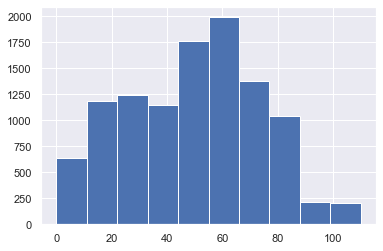

In [21]:
df_age = pd.read_sql("SELECT age FROM fact_table join patientDimension on patient_id == ID",connection)
plt.hist(df_age)
plt.savefig('../artefacts-for-release/age_distribution.png')

Im oberen Diagramm ist ein Histogramm gezeigt, das die Anzahl an Patienten IDs pro Alter abbildet.<br>
Man erkennt, das jede Altersgruppe in unseren Daten vorhanden ist. Die Altersgruppen 50-68 sind verhältnismäßig höher vertreten.

###  BMI-Verteilung

Der Body-Mass-Index, kurz BMI, ist ein Index, um das Verhältnis von Körpergewicht zu Körpergröße zu berechnen. Bekannt ist er auch unter den Abkürzungen KMZ (Körpermassezahl), KMI (Körpermasseindex) und QKI (Quetelet-Kaup-Index). Der Body-Mass-Index ist ein guter Maßstab um schnell festzustellen, ob eine Person ein gesundes Normalgewicht oder an Unter- bzw. Übergewicht leidet.<br>
<br>
Die Verteilung der BMI-Werte in unseren Daten sieht folgendermaßen aus:

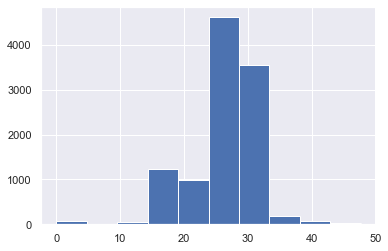

In [22]:
df_bmi = pd.read_sql("SELECT bmi FROM fact_table",connection)
plt.hist(df_bmi)
plt.savefig('../artefacts-for-release/bmi_distribution.png')

Im oben gezeigte Diagramm ist ein Histogramm zu sehen, das die Anzahl an Patienten IDs über ihren BMI abbildet.<br>
Es zeigt sich das in unseren Daten ein großer Piek zwischen den Werten 23.85 und 28.62 entsteht. Nach der [Definition des BMI](https://de.wikipedia.org/wiki/Body-Mass-Index) gelten Menschen mit einem BMI-Wert von >=25 als Übergewichtig und mit >=30 als adipös. Womit der Großteil unserer Patienten an Übergewicht leidet. Nur ca. ein fünftel der Daten liegt im Bereich zwischen 18 und 25, also im Normalgewicht, und <18, also im Untergewicht.

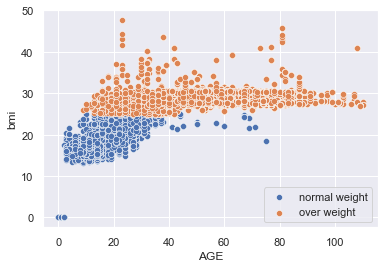

In [23]:
df_age_bmi = pd.read_sql("SELECT age,bmi FROM fact_table join patientDimension on patient_id == ID",connection)
df_norm = df_age_bmi.where(df_age_bmi.bmi<25)
df_overweight = df_age_bmi.where(df_age_bmi.bmi>=25)

sns.scatterplot(x=df_norm.AGE,y=df_norm.bmi,label='normal weight')
sns.scatterplot(x=df_overweight.AGE,y=df_overweight.bmi,label='over weight')
plt.savefig('../artefacts-for-release/ageXbmi_distribution.png')

plt.show()

Das oben gezeigte Punktediagramm zeigt die einzelnen Datenpunkte über BMI und Alter aufgetragen.<br>
Schaut man sich nun die Verteilungen des Alter zum BMI an erkennt man, dass fast alle Patienten mit einem Alter über 40 Jahren an Übergewicht leiden und nur jüngere Patienten im Normalgewicht liegen.

# Krankheitsverteilung

Für unsere Forschungsfrage ist relevant, welche Krankheiten bei den Patienten in unserem Datensatz diagnostiziert wurden:

[]

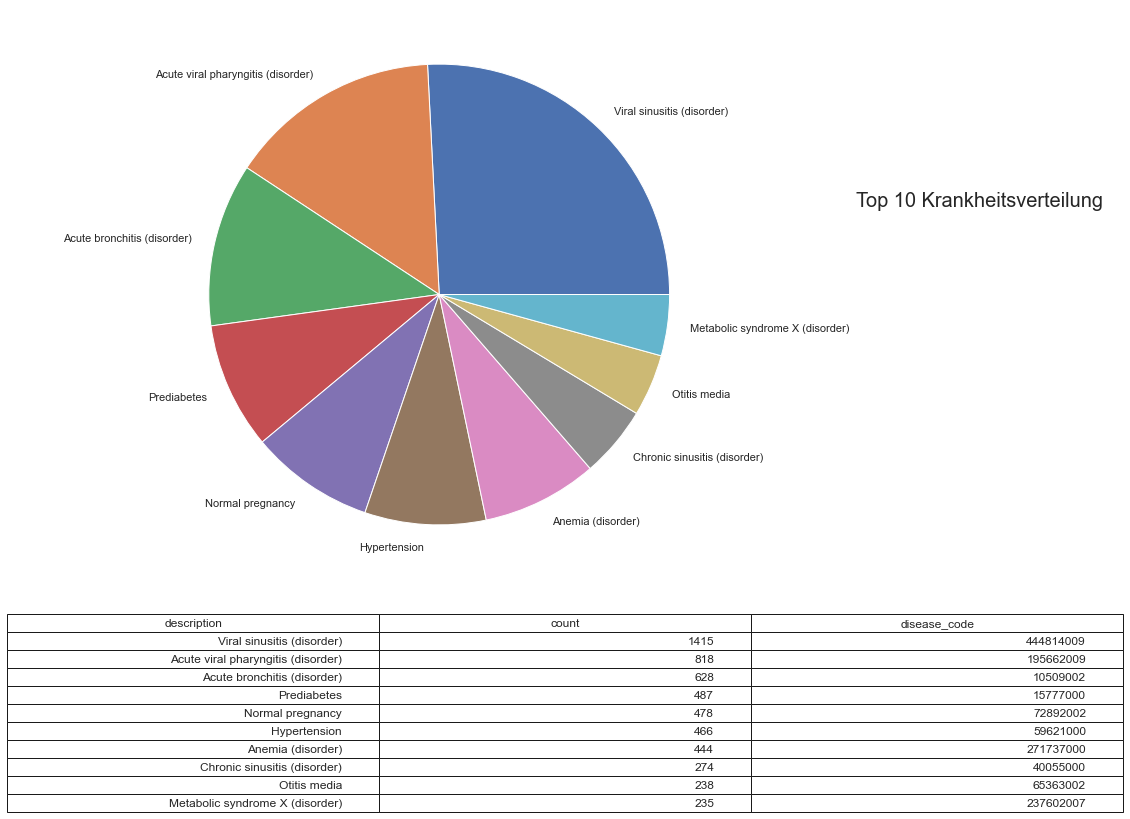

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(5,8)
df_con = pd.read_sql("SELECT patient_id,disease_code,description,bmi\
 FROM fact_table join diseaseDimension on fact_table.disease_code==diseaseDimension.code WHERE description NOT LIKE '%finding%'",connection)

top_ten = pd.DataFrame(df_con['description'].value_counts()[:10]).reset_index()
top_ten = top_ten.rename({'index': 'description', 'description': 'count'}, axis=1)
top_ten['disease_code'] = df_con['disease_code'].value_counts()[:10].index

table = ax[1].table(cellText=top_ten.values, colLabels=top_ten.columns, loc='center',bbox=(-3, -0.65, 4, 1))
table.auto_set_font_size(False)
table.set_fontsize(12)
ax[1].axis('tight')
ax[1].axis('off')

pie = ax[0].pie(df_con['description'].value_counts()[:10],labels=df_con['description'].value_counts()[:10].index)
ax[0].set_position((-3, 0.3, 4, 1))
ax[0].set_facecolor((1.0, 1.0, 1.0))

fig.suptitle("Top 10 Krankheitsverteilung",fontsize=20)

plt.savefig('../artefacts-for-release/disease_distribution.png')
plt.plot()

Im oben abgebildeten Kuchendiagramm sind die Top 10 Krankheiten und ihr jeweiliger Anteil abgebildet.

# Verteilung Beobachtung & Krankheit

Für unserer Forschungsfrage betrachten wir im folgenden das Verhältnnis zwischen dem Aufkommen einer Krankheit und der unten gelisteten Merkmale:


| Name   |      Code      |
|----------|:-------------:|
| Body Height |  8302-2 |
| Body Weight |    29463-7   |
| Body Mass Index | 39156-5 |
| Diastolic Blood Pressure | 8462-4 |
| Systolic Blood Pressure | 8480-6 |
| Heart rate | 8867-4 |

Dabei beschränken wir uns auf die 10 am häuftigsten vorkommenden Krankheiten.

Anlegen eines Dataframes, der die 10 am häufigsten vorkommenden Krankheiten enthält:

In [25]:
disease_codes = top_ten['disease_code'].to_list()
print(disease_codes)
disease_lable = top_ten['description'].to_list()
df_lists = list()
for dis_code,dis_lable in zip(disease_codes,disease_lable):
    sql_pattern = f"""
    SELECT height,weight,bmi,diastolic_blood_pressure,systolic_blood_pressure,heart_rate
        FROM fact_table 
        WHERE disease_code == {dis_code}"""
    df = pd.read_sql(sql_pattern,connection)
    df['disease'] = dis_lable
    df_lists.append(df)    
df_data = pd.concat(df_lists).reset_index(drop=True)
df_data.head()

[444814009, 195662009, 10509002, 15777000, 72892002, 59621000, 271737000, 40055000, 65363002, 237602007]


,height,weight,bmi,diastolic_blood_pressure,systolic_blood_pressure,heart_rate,disease
0,69.9,7.9,0.001617,68.0,133.0,87.0,Viral sinusitis (disorder)
1,176.5,86.0,27.600000,84.0,106.0,92.0,Viral sinusitis (disorder)
2,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder)
3,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder)
4,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder)


Einteilung der BMI-Werte in Klassen:

In [26]:
df_data['class'] = ''
df_data.loc[df_data['bmi'].values<18,'class'] = 'underweight'
df_data.loc[df_data['bmi'].values>=18,'class'] = 'normal'
df_data.loc[df_data['bmi'].values>=25,'class'] = 'overweight'
df_data.loc[df_data['bmi'].values>=30,'class'] = 'obese'
df_data.head()

,height,weight,bmi,diastolic_blood_pressure,systolic_blood_pressure,heart_rate,disease,class
0,69.9,7.9,0.001617,68.0,133.0,87.0,Viral sinusitis (disorder),underweight
1,176.5,86.0,27.600000,84.0,106.0,92.0,Viral sinusitis (disorder),overweight
2,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder),overweight
3,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder),overweight
4,184.5,91.2,26.800000,85.0,99.0,69.0,Viral sinusitis (disorder),overweight


# Beantwortung der Forschungsfrage

Zur Beantwortung unserer Forschungsfrage schauen wir uns die Verteilung der BMI-Werte für die jeweiligen Krankheiten an:

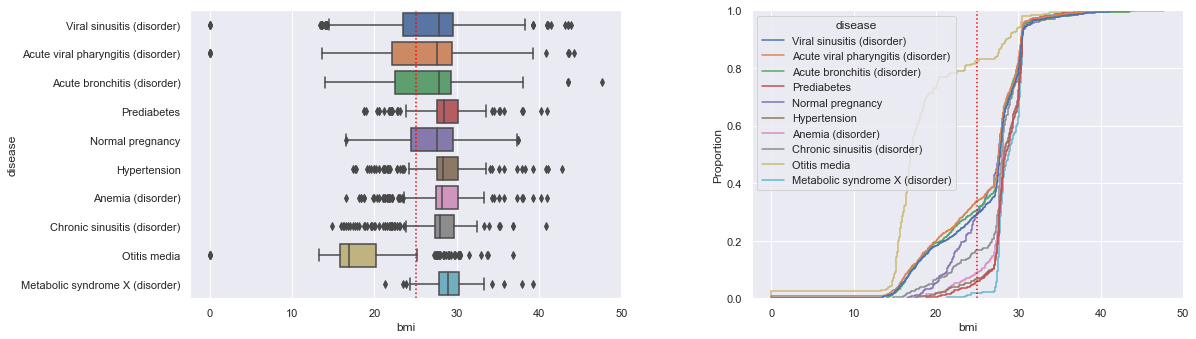

In [27]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.boxplot(x="bmi", y="disease", data=df_data,ax=ax[0])
ax[0].axvline(x=25, c='red',ls=':')
ax[0].set_position((-2.5,-0.1, 1, 1))

sns.ecdfplot(data=df_data, x="bmi",hue='disease',ax=ax[1])
ax[1].axvline(x=25, c='red',ls=':')
ax[1].set_position((-1.2, -0.1, 1, 1))

plt.savefig('../artefacts-for-release/distribution.png')
plt.show()

In [28]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return (x,y)

for disease in disease_lable:
    dis_df = df_data.where(df_data['disease']==disease)
    dis_df = dis_df.dropna()
    ecdf_dis = ecdf(dis_df['bmi'])
    for i,j in enumerate(ecdf_dis[0]):
        if j >=28:
            logger.log(f"{disease} distribution is with a bmi value from >=25 by {1-ecdf_dis[1][i]}")
            break



{"type": "info", "time": 1658308496936, "message": "Viral sinusitis (disorder) distrubution is  with a bmi value from >=25 by 0.45371024734982335", "params": null}
{"type": "info", "time": 1658308496952, "message": "Acute viral pharyngitis (disorder) distrubution is  with a bmi value from >=25 by 0.4070904645476773", "params": null}
{"type": "info", "time": 1658308496967, "message": "Acute bronchitis (disorder) distrubution is  with a bmi value from >=25 by 0.445859872611465", "params": null}
{"type": "info", "time": 1658308496980, "message": "Prediabetes distrubution is  with a bmi value from >=25 by 0.6262833675564682", "params": null}
{"type": "info", "time": 1658308496990, "message": "Normal pregnancy distrubution is  with a bmi value from >=25 by 0.42050209205020916", "params": null}
{"type": "info", "time": 1658308497007, "message": "Hypertension distrubution is  with a bmi value from >=25 by 0.6137339055793991", "params": null}
{"type": "info", "time": 1658308497022, "message": 

In den Box-Plots (linke Abbildung) lässt sich klar erkennen, dass die Mehrheit der Patienten unter den Top 10 Krankheiten unter Übergewicht leiden (rote Line). Bei folgenden Krankheiten haben die Patienten einen besonders hohen BMI:

* Hypertension (Bluthochdruck)
* Prediabetes
* Anemia
* Chronic sinusitis
* Metabolic syndrome X

Das wird auch in der Verteilungsfunktion (rechte Abbildung) verdeutlicht, bei der der BMI-Wert bei ca. 28 einen starken Sprung in der Verteilung zeigt. Damit kann bei der relativen Häufigkeit unsere Daten davon ausgegangen werden, dass es eine 80 prozentige Chance gibt an allen Krankheiten außer Otitis media zu erkranken, falls der BMI-Wert >=30 ist.

# Prognosen mittels [Entscheidungsbaum](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

Da wir nun festgestellt haben, dass der BMI-Wert einen großen Einfluss auf die häufigsten Krankheiten habt, stellten wir nun einen Entscheidungsbaum mit zusätzlichen Merkmalen auf, die bekanntlich auch hypo- hypertensiv mit Übergewicht zusammenhängen.

In [29]:
df_tree = df_data.dropna()
X, y = df_tree.drop(['disease','class'],axis=1), df_tree['disease']
clf = tree.DecisionTreeClassifier(max_depth=5,max_features='sqrt',random_state=42)
clf = clf.fit(X, y)
[print("X",i,":",e) for i,e in enumerate(X.columns)]

X 0 : height
X 1 : weight
X 2 : bmi
X 3 : diastolic_blood_pressure
X 4 : systolic_blood_pressure
X 5 : heart_rate


[None, None, None, None, None, None]

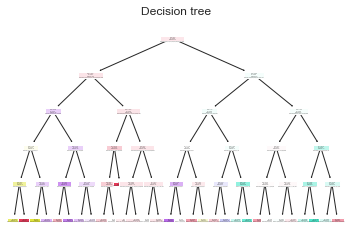

In [30]:
from sklearn.tree import plot_tree

plt.figure()
plot_tree(clf, filled=True)
plt.title("Decision tree")
plt.savefig('../images/decision_tree.svg')
plt.savefig('../artefacts-for-release/decision_tree.png', dpi=400)
plt.show()

Am Entscheidungsbaum zeigt sich, dass der Wert des diastolischen Blutdrucks eines Patienten schon die größte Teilmengen zwischen den einzelnen Krankheiten unterscheiden kann. Der BMI folgt jedoch auch schon in der zweiten Ebene zur Teilung der Nodes. Für einer bessere Übersicht über den Entscheidungsbaum bitte [hier](https://github.com/Fuenfgeld/DMA2022DataProjectC/blob/main/images/decision_tree.png) klicken.

# Aufräumen & Logs speichern

In [31]:
connection.close()
logger.logTimings()
logger.writeToFile("../artefacts-for-release/analysis-log.json")

{"type": "info", "time": 1658308516505, "message": "⏳ Connected to db and created tables in 386490ms", "params": {"timingInMilliseconds": 386490}}
{"type": "info", "time": 1658308516505, "message": "Time measurement for open-db not finished", "params": null}
